<a href="https://colab.research.google.com/github/MayerT1/Prithvi_DEV/blob/main/Prithvi_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-600M
*   https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-EO-2.0-Demo
*   https://search.earthdata.nasa.gov/search?fpj=HLS&as[project][0]=HLS
*   https://huggingface.co/docs/transformers/en/model_doc/auto




In [14]:
#https://github.com/IBM/terratorch/blob/main/terratorch/models/backbones/prithvi_vit.py
!pip install git+https://github.com/IBM/terratorch.git


  Cloning https://github.com/IBM/terratorch.git to /tmp/pip-req-build-c2jc4hud
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/terratorch.git /tmp/pip-req-build-c2jc4hud
  Resolved https://github.com/IBM/terratorch.git to commit 696857654b70986b257714be425bdf2e72264027
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:

import os
import sys
import numpy as np
import torch

import terratorch
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
from terratorch.tasks import SemanticSegmentationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint



from terratorch.registry import BACKBONE_REGISTRY

model = BACKBONE_REGISTRY.build("ibm-nasa-geospatial/Prithvi-EO-2.0-600M")

ImportError: cannot import name 'EncoderDecoderCache' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

In [2]:
# STEP 1: Install required packages
!pip install transformers datasets huggingface_hub torch torchvision rasterio --quiet

In [ ]:
# !pip install --upgrade transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/Shareddrives/SCO-Shared/Science Resources/Data Science/Prithvi_Dev

/content/drive/Shareddrives/SCO-Shared/Science Resources/Data Science/Prithvi_Dev


In [5]:
!ls

input_tifs					       Prithvi-EO-2.0
Mexico_HLS.S30.T13REM.2018026T173609.v2.0_cropped.tif  t1.tif
Mexico_HLS.S30.T13REM.2018106T172859.v2.0_cropped.tif  t2.tif
Mexico_HLS.S30.T13REM.2018201T172901.v2.0_cropped.tif  t3.tif
Mexico_HLS.S30.T13REM.2018266T173029.v2.0_cropped.tif  t4.tif


In [6]:
# STEP 2: Import necessary libraries
import torch
from transformers import AutoModelForMaskedImageModeling, AutoImageProcessor
from huggingface_hub import hf_hub_download
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision import transforms

In [25]:
# # STEP 2: Import necessary libraries
# import torch
# import numpy as np
# import rasterio
# import os
# import matplotlib.pyplot as plt
# from torchvision.transforms import Compose, Resize, ToTensor, Normalize
# from torchvision.transforms.functional import to_pil_image
# # from transformers import MAEForPreTraining

In [7]:
# STEP 4: Load and stack the HLS TIFs
tif_files = [
    "Mexico_HLS.S30.T13REM.2018026T173609.v2.0_cropped.tif",
    "Mexico_HLS.S30.T13REM.2018106T172859.v2.0_cropped.tif",
    "Mexico_HLS.S30.T13REM.2018201T172901.v2.0_cropped.tif",
    "Mexico_HLS.S30.T13REM.2018266T173029.v2.0_cropped.tif"
]

tif_files

['Mexico_HLS.S30.T13REM.2018026T173609.v2.0_cropped.tif',
 'Mexico_HLS.S30.T13REM.2018106T172859.v2.0_cropped.tif',
 'Mexico_HLS.S30.T13REM.2018201T172901.v2.0_cropped.tif',
 'Mexico_HLS.S30.T13REM.2018266T173029.v2.0_cropped.tif']

In [8]:
def load_stack_tifs(file_list):
    arrays = []
    for f in file_list:
        with rasterio.open(f) as src:
            array = src.read()
            arrays.append(array)
    stacked = np.stack(arrays, axis=0)  # Shape: (T, C, H, W)
    return stacked

stacked_tifs = load_stack_tifs(tif_files)  # Shape: (T, C, H, W)
stacked_tifs

array([[[[ 836,  821,  382, ..., 1104, 1095, 1128],
         [ 809,  902,  625, ..., 1120, 1165, 1079],
         [ 780,  849,  938, ..., 1136, 1145, 1052],
         ...,
         [ 753,  764,  732, ...,  772,  825,  810],
         [ 771,  778,  783, ...,  738,  756,  855],
         [ 771,  752,  779, ...,  692,  744,  829]],

        [[1250, 1279,  714, ..., 1529, 1514, 1538],
         [1212, 1370, 1025, ..., 1535, 1592, 1468],
         [1162, 1276, 1457, ..., 1564, 1568, 1444],
         ...,
         [1100, 1123, 1076, ..., 1092, 1142, 1127],
         [1131, 1148, 1215, ..., 1077, 1050, 1195],
         [1117, 1107, 1182, ...,  998, 1060, 1180]],

        [[1911, 2000,  971, ..., 2045, 2028, 2052],
         [1793, 2126, 1582, ..., 2043, 2119, 1973],
         [1695, 1952, 2277, ..., 2087, 2090, 1944],
         ...,
         [1584, 1591, 1520, ..., 1433, 1478, 1490],
         [1608, 1631, 1734, ..., 1406, 1366, 1566],
         [1604, 1570, 1692, ..., 1290, 1397, 1537]],

        [[2562, 

In [32]:
stacked_tifs.min()


np.int16(-113)

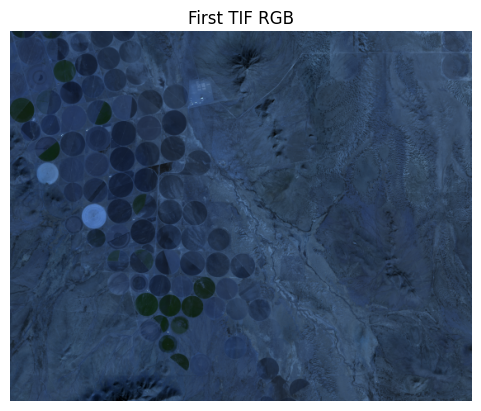

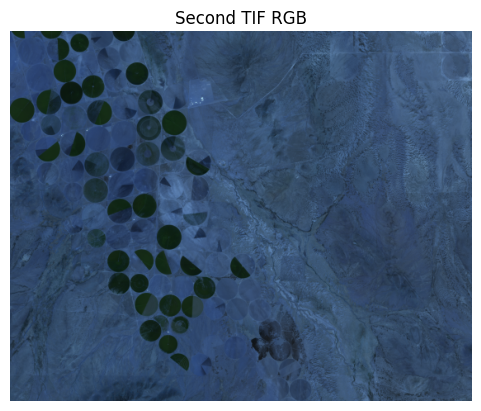

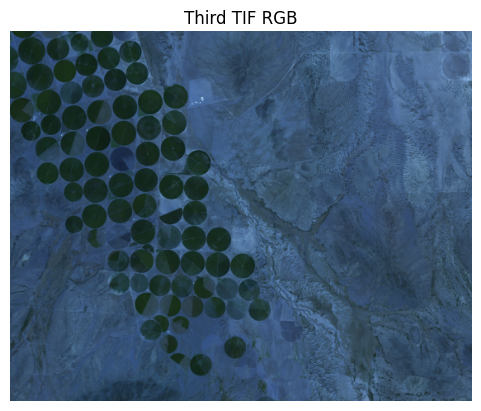

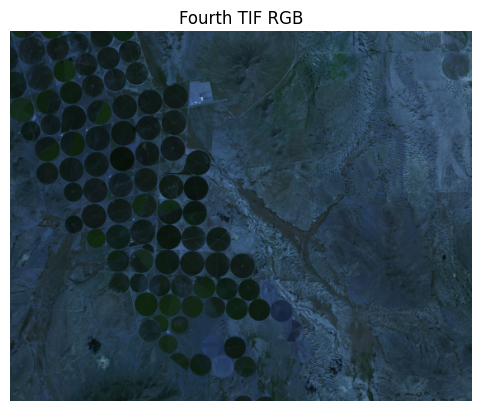

In [9]:
# Optional: Select a single image (timestamp) and RGB bands for visualization
def visualize_image(image_tensor, title=""):
    img = image_tensor[:3, :, :]  # RGB
    img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
    plt.imshow(img / img.max())
    plt.title(title)
    plt.axis('off')
    plt.show()

visualize_image(stacked_tifs[0], title="First TIF RGB")
visualize_image(stacked_tifs[1], title="Second TIF RGB")
visualize_image(stacked_tifs[2], title="Third TIF RGB")
visualize_image(stacked_tifs[3], title="Fourth TIF RGB")


In [12]:
#https://github.com/IBM/terratorch/blob/main/terratorch/models/backbones/prithvi_vit.py
!pip install git+https://github.com/IBM/terratorch.git
import terratorch
from terratorch.registry import BACKBONE_REGISTRY

model = BACKBONE_REGISTRY.build("ibm-nasa-geospatial/Prithvi-EO-2.0-600M")

  Cloning https://github.com/IBM/terratorch.git to /tmp/pip-req-build-r9xfx0xb
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/terratorch.git /tmp/pip-req-build-r9xfx0xb
  Resolved https://github.com/IBM/terratorch.git to commit 696857654b70986b257714be425bdf2e72264027
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


ImportError: cannot import name 'EncoderDecoderCache' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

In [36]:
# # STEP 5: Load Prithvi model and processor
# model_name = "ibm-nasa-geospatial/Prithvi-EO-2.0-600M"
# processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModelForMaskedImageModeling.from_pretrained(model_name)

OSError: ibm-nasa-geospatial/Prithvi-EO-2.0-600M does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-600M/main' for available files.

In [ ]:
# STEP 6: Preprocess one image
# Let's assume the model expects (3, H, W) image, rescaled and normalized
# Select one sample (e.g. RGB bands from the first timestamp)
# Depending on the model, you may need to ensure it's in RGB format (first 3 bands)

sample = stacked_tifs[0][:3, :, :]  # (C=3, H, W)

# Convert to PIL for processing
from torchvision.transforms.functional import to_pil_image
img_pil = to_pil_image(sample / sample.max())  # Normalize for display

# Apply processor
inputs = processor(images=img_pil, return_tensors="pt")


In [ ]:
# STEP 7: Inference
with torch.no_grad():
    outputs = model(**inputs)

# Output is a dict; for example, you can inspect the loss or logits
print("Output keys:", outputs.keys())

# Optional: You can visualize the reconstructed image (if output available)
if 'logits' in outputs:
    reconstructed = outputs.logits
    print("Logits shape:", reconstructed.shape)

